In [1]:
import os
import h5py
import librosa
import itertools
from copy import copy
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

/home/srd/Desktop/music/venv_python3.7/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/home/srd/Desktop/music/venv_python3.7/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [2]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import PReLU
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [3]:
# For reproducibility purposes
np.random.seed(42)

# Read the data

> Helper functions to assist the process to read songs, split then and return an array of spectrograms/melspectrograms

In [4]:
"""
@description: Method to split a song into multiple songs using overlapping windows
"""
def splitsongs(X, y, window = 0.05, overlap = 0.5):
    # Empty lists to hold our results
    temp_X = []
    temp_y = []

    # Get the input song array size
    xshape = X.shape[0]
    chunk = int(xshape*window)
    offset = int(chunk*(1.-overlap))
    
    # Split the song and create new ones on windows
    spsong = [X[i:i+chunk] for i in range(0, xshape - chunk + offset, offset)]
    for s in spsong:
        if s.shape[0] != chunk:
            continue

        temp_X.append(s)
        temp_y.append(y)

    return np.array(temp_X), np.array(temp_y)

In [5]:
"""
@description: Method to convert a list of songs to a np array of melspectrograms
"""
def to_melspectrogram(songs, n_fft=1024, hop_length=256):
    # Transformation function
    melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
        hop_length=hop_length, n_mels=128)[:,:,np.newaxis]

    # map transformation of input songs to melspectrogram using log-scale
    tsongs = map(melspec, songs)
    # np.array([librosa.power_to_db(s, ref=np.max) for s in list(tsongs)])
    return np.array(list(tsongs))

In [6]:
def split_convert(X, y):
    arr_specs, arr_genres = [], []
    
    # Convert to spectrograms and split into small windows
    for fn, genre in zip(X, y):
        signal, sr = librosa.load(fn)
        signal = signal[:song_samples]

        # Convert to dataset of spectograms/melspectograms
        signals, y = splitsongs(signal, genre)

        # Convert to "spec" representation
        specs = to_melspectrogram(signals)

        # Save files
        arr_genres.extend(y)
        arr_specs.extend(specs)
    
    return np.array(arr_specs), to_categorical(arr_genres)

In [7]:
def read_data(src_dir, genres, song_samples):    
    # Empty array of dicts with the processed features from all files
    arr_fn = []
    arr_genres = []

    # Get file list from the folders
    for x,_ in genres.items():
        folder = src_dir + x
        for root, subdirs, files in os.walk(folder):
            for file in files:
                file_name = folder + "/" + file

                # Save the file name and the genre
                arr_fn.append(file_name)
                arr_genres.append(genres[x])
    
    # Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(
        arr_fn, arr_genres, test_size=0.3, random_state=42, stratify=arr_genres
    )
    
    # Split into small segments and convert to spectrogram
    X_train, y_train = split_convert(X_train, y_train)
    X_test, y_test = split_convert(X_test, y_test)

    return X_train, X_test, y_train, y_test

In [8]:
# Parameters
gtzan_dir = '../data/genres/'
song_samples = 660000
genres = {'metal': 0, 'disco': 1, 'classical': 2, 'hiphop': 3, 'jazz': 4, 
          'country': 5, 'pop': 6, 'blues': 7, 'reggae': 8, 'rock': 9}

# Read the data
X_train, X_test, y_train, y_test = read_data(gtzan_dir, genres, song_samples)

In [9]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(27300, 128, 129, 1) (11700, 128, 129, 1) (27300, 10) (11700, 10)


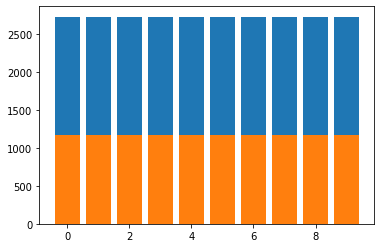

In [10]:
# Histogram for train and test 
values, count = np.unique(np.argmax(y_train, axis=1), return_counts=True)
plt.bar(values, count)

values, count = np.unique(np.argmax(y_test, axis=1), return_counts=True)
plt.bar(values, count)
plt.show()

# GTZAN Melspectrogram Generator

In [11]:
from tensorflow.keras.utils import Sequence

class GTZANGenerator(Sequence):
    def __init__(self, X, y, batch_size=64, is_test = False):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.is_test = is_test
    
    def __len__(self):
        return int(np.ceil(len(self.X)/self.batch_size))
    
    def __getitem__(self, index):
        # Get batch indexes
        signals = self.X[index*self.batch_size:(index+1)*self.batch_size]

        # Apply data augmentation
        if not self.is_test:
            signals = self.__augment(signals)
        return signals, self.y[index*self.batch_size:(index+1)*self.batch_size]
    
    def __augment(self, signals, hor_flip = 0.5, random_cutout = 0.5):
        spectrograms =  []
        for s in signals:
            signal = copy(s)
            
            # Perform horizontal flip
            if np.random.rand() < hor_flip:
                signal = np.flip(signal, 1)

            # Perform random cutoout of some frequency/time
            if np.random.rand() < random_cutout:
                lines = np.random.randint(signal.shape[0], size=3)
                cols = np.random.randint(signal.shape[0], size=4)
                signal[lines, :, :] = -80 # dB
                signal[:, cols, :] = -80 # dB

            spectrograms.append(signal)
        return np.array(spectrograms)
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.X))
        np.random.shuffle(self.indexes)
        return None

# Custom CNN (Melspectrogram version)

In [12]:
def conv_block(x, n_filters, pool_size=(2, 2)):
    x = Conv2D(n_filters, (3, 3), strides=(1, 1), padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=pool_size, strides=pool_size)(x)
    x = Dropout(0.25)(x)
    return x

In [13]:
# Model Definition
def create_model(input_shape, num_genres):
    inpt = Input(shape=input_shape)
    x = conv_block(inpt, 16)
    x = conv_block(x, 32)
    x = conv_block(x, 64)
    x = conv_block(x, 128)
    x = conv_block(x, 256)
    
    # Global Pooling and MLP
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu', 
              kernel_regularizer=tf.keras.regularizers.l2(0.02))(x)
    x = Dropout(0.25)(x)
    predictions = Dense(num_genres, 
                        activation='softmax', 
                        kernel_regularizer=tf.keras.regularizers.l2(0.02))(x)
    
    model = Model(inputs=inpt, outputs=predictions)
    return model

In [14]:
model = create_model(X_train[0].shape, 10)

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 129, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 129, 16)      160       
_________________________________________________________________
activation (Activation)      (None, 128, 129, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 32)        0     

### Loss function

In [16]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [17]:
reduceLROnPlat = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.95,
    patience=3,
    verbose=1,
    mode='min',
    min_delta=0.0001,
    cooldown=2,
    min_lr=1e-5
)

In [18]:
# Generators
batch_size = 128
train_generator = GTZANGenerator(X_train, y_train)
steps_per_epoch = np.ceil(len(X_train)/batch_size)

validation_generator = GTZANGenerator(X_test, y_test)
val_steps = np.ceil(len(X_test)/batch_size)

In [19]:
hist = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=val_steps,
    epochs=150,
    verbose=1,
    callbacks=[reduceLROnPlat])

Epoch 1/150
214/214 [==============================] - 116s 541ms/step - loss: 8.2643 - accuracy: 0.1388 - val_loss: 3.1057 - val_accuracy: 0.1598
Epoch 2/150
214/214 [==============================] - 115s 538ms/step - loss: 2.5984 - accuracy: 0.1904 - val_loss: 2.3648 - val_accuracy: 0.2011
Epoch 3/150
214/214 [==============================] - 116s 542ms/step - loss: 2.2849 - accuracy: 0.1843 - val_loss: 2.2174 - val_accuracy: 0.1990
Epoch 4/150
214/214 [==============================] - 116s 544ms/step - loss: 2.2112 - accuracy: 0.1888 - val_loss: 2.2455 - val_accuracy: 0.1686
Epoch 5/150
214/214 [==============================] - 117s 546ms/step - loss: 2.1364 - accuracy: 0.2112 - val_loss: 2.1680 - val_accuracy: 0.2092
Epoch 6/150
214/214 [==============================] - 117s 548ms/step - loss: 2.0961 - accuracy: 0.2188 - val_loss: 2.1660 - val_accuracy: 0.2094
Epoch 7/150
214/214 [==============================] - 118s 552ms/step - loss: 2.0707 - accuracy: 0.2417 - val_loss: 2

213/214 [============================>.] - ETA: 0s - loss: 1.4930 - accuracy: 0.5087
Epoch 00054: ReduceLROnPlateau reducing learning rate to 0.0008573750033974647.
214/214 [==============================] - 117s 545ms/step - loss: 1.4910 - accuracy: 0.5105 - val_loss: 1.5869 - val_accuracy: 0.4614
Epoch 55/150
214/214 [==============================] - 117s 546ms/step - loss: 1.4749 - accuracy: 0.5080 - val_loss: 1.5228 - val_accuracy: 0.4677
Epoch 56/150
214/214 [==============================] - 120s 562ms/step - loss: 1.5196 - accuracy: 0.5053 - val_loss: 1.4926 - val_accuracy: 0.5499
Epoch 57/150
214/214 [==============================] - 133s 622ms/step - loss: 1.4599 - accuracy: 0.5299 - val_loss: 1.5007 - val_accuracy: 0.4988
Epoch 58/150
214/214 [==============================] - 128s 597ms/step - loss: 1.4212 - accuracy: 0.5329 - val_loss: 1.4543 - val_accuracy: 0.5542
Epoch 59/150
214/214 [==============================] - 123s 576ms/step - loss: 1.5451 - accuracy: 0.4819 - 

214/214 [==============================] - 121s 565ms/step - loss: 1.1869 - accuracy: 0.6341 - val_loss: 1.2240 - val_accuracy: 0.6270
Epoch 100/150
214/214 [==============================] - 121s 566ms/step - loss: 1.1538 - accuracy: 0.6471 - val_loss: 1.2350 - val_accuracy: 0.6185
Epoch 101/150
214/214 [==============================] - 120s 560ms/step - loss: 1.1321 - accuracy: 0.6635 - val_loss: 1.2359 - val_accuracy: 0.6384
Epoch 102/150
213/214 [============================>.] - ETA: 0s - loss: 1.1370 - accuracy: 0.6494
Epoch 00102: ReduceLROnPlateau reducing learning rate to 0.0005403600225690752.
214/214 [==============================] - 121s 563ms/step - loss: 1.1402 - accuracy: 0.6488 - val_loss: 1.3108 - val_accuracy: 0.6026
Epoch 103/150
214/214 [==============================] - 121s 566ms/step - loss: 1.1453 - accuracy: 0.6392 - val_loss: 1.2407 - val_accuracy: 0.6255
Epoch 104/150
214/214 [==============================] - 120s 563ms/step - loss: 1.1156 - accuracy: 0.66

214/214 [==============================] - 128s 597ms/step - loss: 0.9899 - accuracy: 0.6921 - val_loss: 1.1950 - val_accuracy: 0.6281
Epoch 145/150
214/214 [==============================] - 118s 550ms/step - loss: 0.8871 - accuracy: 0.7404 - val_loss: 1.1572 - val_accuracy: 0.6503
Epoch 146/150
214/214 [==============================] - 115s 539ms/step - loss: 0.9908 - accuracy: 0.6940 - val_loss: 1.1863 - val_accuracy: 0.6506
Epoch 147/150
213/214 [============================>.] - ETA: 0s - loss: 0.9733 - accuracy: 0.7082
Epoch 00147: ReduceLROnPlateau reducing learning rate to 0.00034056155709549785.
214/214 [==============================] - 113s 527ms/step - loss: 0.9717 - accuracy: 0.7088 - val_loss: 1.1896 - val_accuracy: 0.6104
Epoch 148/150
214/214 [==============================] - 116s 540ms/step - loss: 0.9299 - accuracy: 0.7184 - val_loss: 1.1664 - val_accuracy: 0.6423
Epoch 149/150
214/214 [==============================] - 118s 549ms/step - loss: 0.9873 - accuracy: 0.6

In [20]:
score = model.evaluate(X_test, y_test, verbose=0)
print("val_loss = {:.3f} and val_acc = {:.3f}".format(score[0], score[1]))

val_loss = 1.068 and val_acc = 0.676


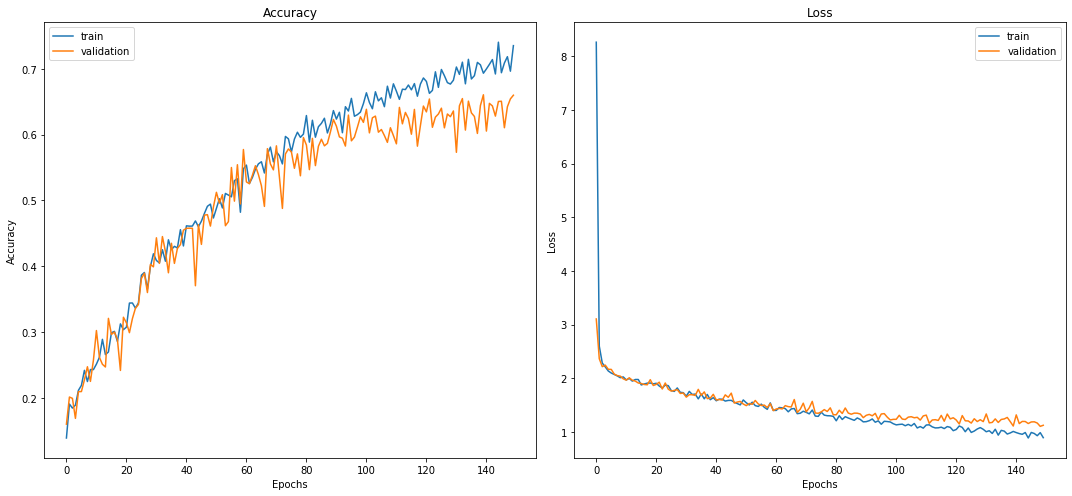

In [21]:
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [22]:
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [23]:
preds = np.argmax(model.predict(X_test), axis = 1)
y_orig = np.argmax(y_test, axis = 1)
cm = confusion_matrix(preds, y_orig)

Normalized confusion matrix


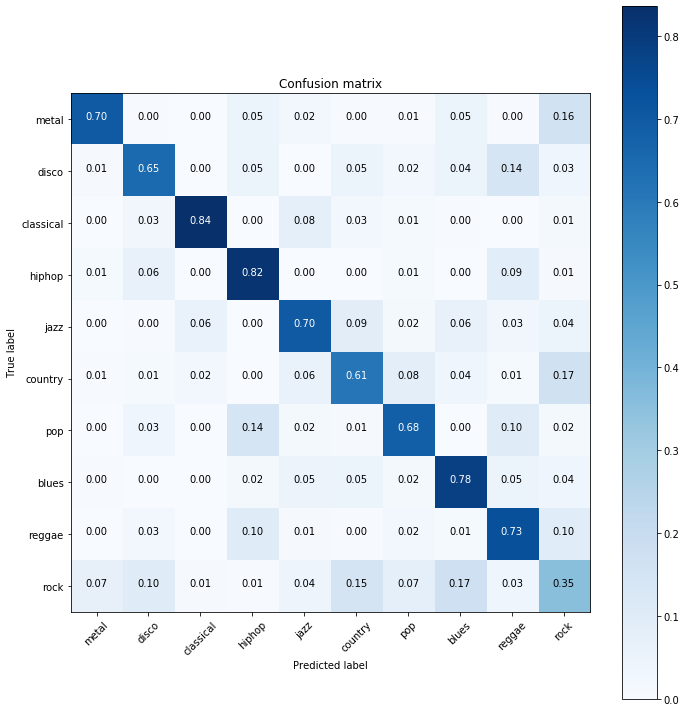

In [24]:
keys = OrderedDict(sorted(genres.items(), key=lambda t: t[1])).keys()

plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, keys, normalize=True)

## Majority Vote

In [25]:
def majority_vote(scores):
    values, counts = np.unique(scores,return_counts=True)
    ind = np.argmax(counts)
    return values[ind]

In [26]:
preds = model.predict(X_test, batch_size=128, verbose=0)

In [27]:
# Each sound was divided into 39 segments in our custom function
scores_songs = np.split(np.argmax(preds, axis=1), 300)
scores_songs = [majority_vote(scores) for scores in scores_songs]

In [28]:
# Same analysis for split
label = np.split(np.argmax(y_test, axis=1), 300)
label = [majority_vote(l) for l in label]

In [29]:
from sklearn.metrics import accuracy_score

print("majority voting system (acc) = {:.3f}".format(accuracy_score(label, scores_songs)))

majority voting system (acc) = 0.740


Compared to the classical approach, we are winning now!

We passed from a 78.8% accuracy to **82%**. It is not a great improvement but this is a really simple architecture.

## Save the model

In [30]:
# Save the model
model.save('../models/custom_cnn_2d.h5')